# Metodologia de Classificação Climática das Cidades

### Desenvolvido por: **[Seu Nome Aqui]**

---

## 1. Objetivo

Avaliar o conforto climático anual de diferentes cidades a partir de dados meteorológicos diários, criando um **ranking por categorias** facilmente compreensível para o público em geral.

---

## 2. Dados Utilizados

- **Temperatura máxima e mínima diária (°C)**
- **Sensação térmica (FeelsLikeC)**
- **Umidade relativa (%)**
- **Precipitação (mm)**
- **Horas de sol por dia**
- **Índice UV**
- **Ocorrência de eventos extremos** (calor, frio, chuva, neve, radiação UV)

**Fontes dos dados:**  
- **World Weather Online**  
- **Instituto Português do Mar e da Atmosfera (IPMA)**  
- **Open-Meteo**  
- Outras APIs de meteorologia confiáveis

---

## 3. Detecção de Eventos Extremos

São considerados dias extremos quando ocorrem:

- **Calor extremo:** Temperatura máxima > 35°C ou Heat Index > 40°C
- **Frio extremo:** Temperatura mínima < -3°C ou Wind Chill < -5°C
- **Chuva extrema:** Precipitação diária > 20 mm
- **Neve:** Qualquer valor de neve > 0 cm
- **Radiação UV extrema:** Índice UV ≥ 8

Esses dias são contados e penalizam a nota final de conforto, pois representam situações de desconforto ou risco à saúde.

---

## 4. Cálculo do Clima Típico

Para calcular o clima típico (médio), são **removidos os dias extremos** identificados acima. A partir dos dias restantes, calcula-se:

- **Temperatura máxima e mínima médias**
- **Umidade média**
- **Precipitação média**
- **Horas de sol médias**
- **Índice UV médio**

---

## 5. Score de Conforto Climático

O **score** de conforto é composto pelos seguintes fatores, baseados nos dias típicos (sem extremos):

- **Temperatura Máxima Ideal:** Proporção dos dias em que a máxima ficou entre 22°C e 28°C (pontuação máxima).
- **Temperatura Moderada:** Proporção dos dias com máxima entre 18°C e 32°C (pontuação intermediária).
- **Umidade Confortável:** Proporção dos dias com umidade entre 30% e 80%.
- **Sol:** Proporção dos dias com mais de 5 horas de sol.
- **Precipitação:** Proporção dos dias com chuva ≤ 20mm.

**Ponderação dos fatores no score:**

- 40% Temperatura máxima confortável
- 20% Umidade confortável
- 20% Horas de sol
- 20% Precipitação confortável

### Penalização por extremos

Ao score acima, subtrai-se uma penalização proporcional à quantidade de dias extremos anuais (sempre considerando todos os dias do ano):

- **Calor extremo:** -0.3 ponto por dia
- **Chuva extrema:** -0.2 ponto por dia
- **Frio extremo:** -0.4 ponto por dia
- **Limite máximo de penalização:** 20 pontos

O score final é truncado entre 0 e 100.

---

## 6. Classificação por Categoria

O score final determina a **categoria climática** da cidade:

| Score      | Categoria    |
|------------|--------------|
| ≥ 80       | Excelente    |
| ≥ 70       | Muito Bom    |
| ≥ 60       | Bom          |
| ≥ 50       | Aceitável    |
| < 50       | Marginal     |

---

## 7. Tourism Climate Index (TCI)

Além do score personalizado, é calculado também o **TCI** tradicional (Mieczkowski, 1985), que leva em conta temperatura, umidade, chuva, insolação e vento, facilitando comparações internacionais.

---

## 8. Exemplos de Resultados

| Cidade      | Score | Categoria   | Máxima Média (°C) | Mínima Média (°C) | Eventos Extremos |
|-------------|-------|-------------|-------------------|-------------------|------------------|
| **Lisboa**  | 87    | Excelente   | 25,3              | 14,7              | 6                |
| **Porto**   | 80    | Excelente   | 22,8              | 13,2              | 12               |
| **São Paulo** | 71   | Muito Bom   | 28,3              | 16,9              | 32               |

> *Obs.: Os valores são apenas ilustrativos, simulando os resultados reais esperados após aplicar toda a metodologia sobre o histórico anual de cada cidade.*

---

## 9. Resultados e Apresentação

- Cidades são agrupadas por categoria e ordenadas por score.
- O resultado inclui, para cada cidade: score, categoria, número de eventos extremos, temperatura máxima e mínima médias.
- A localização das cidades é mostrada em um mapa de Portugal, colorido conforme a categoria.

---

## 10. Observações Importantes

- O método foi ajustado para privilegiar cidades com clima moderado, evitando supervalorizar cidades muito frias ou quentes.
- O cálculo não substitui estudos detalhados de conforto climático ou turismo, mas oferece um panorama acessível, prático e transparente.

---

**Dúvidas ou sugestões? Entre em contato com [Seu Nome Aqui] para saber mais sobre a metodologia!**


In [139]:
import pandas as pd
import numpy as np
import os

# === FUNÇÕES DE DETECÇÃO DE EVENTOS EXTREMOS ===
def is_hot_extreme(row):
    """
    Identifica evento de calor extremo:
    - Temperatura máxima > 35°C OU Heat Index > 40°C.
    """
    return row['maxtempC'] > 35 or row['HeatIndexC'] > 40

def is_cold_extreme(row):
    """
    Identifica evento de frio extremo:
    - Temperatura mínima < -3°C OU Wind Chill < -5°C.
    """
    return row['mintempC'] < -3 or row['WindChillC'] < -5

def is_rain_extreme(row):
    """
    Identifica chuva extrema:
    - Precipitação diária > 20 mm.
    """
    return row['precipMM'] > 20

def is_snow_extreme(row):
    """
    Identifica presença de neve:
    - Qualquer valor positivo já é evento extremo em Portugal continental.
    """
    return row['totalSnow_cm'] > 0

def is_uv_extreme(row):
    """
    Identifica radiação UV extrema:
    - Índice UV >= 8 (OMS: muito alto).
    """
    return row['uvIndex'] >= 8

# === FUNÇÕES AUXILIARES ===
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Inverno'
    elif month in [3, 4, 5]:
        return 'Primavera'
    elif month in [6, 7, 8]:
        return 'Verão'
    else:
        return 'Outono'

def classify_city_index(score):
    if score >= 80:
        return 'Excelente'
    elif score >= 70:
        return 'Muito Bom'
    elif score >= 60:
        return 'Bom'
    elif score >= 50:
        return 'Aceitável'
    else:
        return 'Marginal'

# === CÁLCULO DO TCI - Tourism Climate Index ===
def compute_tci_monthly(df):
    df['month'] = df['date_time'].dt.month
    tci_list = []
    for (year, month), dfg in df.groupby([df['date_time'].dt.year, 'month']):
        # ---- CID: conforto diário (temp média)
        tmean = dfg['tempC'].mean()
        rhmean = dfg['humidity'].mean()
        if 20 <= tmean <= 27:
            cid = 10
        elif 16 <= tmean < 20 or 27 < tmean <= 30:
            cid = 7
        elif 13 <= tmean < 16 or 30 < tmean <= 33:
            cid = 5
        elif 10 <= tmean < 13 or 33 < tmean <= 36:
            cid = 3
        else:
            cid = 0
        if rhmean > 90 or rhmean < 30:
            cid -= 1

        # ---- CIA: conforto amplitude diária (temp máxima)
        tmax = dfg['maxtempC'].mean()
        rhmax = dfg['humidity'].mean()
        if 20 <= tmax <= 27:
            cia = 10
        elif 16 <= tmax < 20 or 27 < tmax <= 30:
            cia = 7
        elif 13 <= tmax < 16 or 30 < tmax <= 33:
            cia = 5
        elif 10 <= tmax < 13 or 33 < tmax <= 36:
            cia = 3
        else:
            cia = 0
        if rhmax > 90 or rhmax < 30:
            cia -= 1

        # ---- P: índice de precipitação do mês
        p = dfg['precipMM'].sum()
        if p <= 30:
            pi = 10
        elif p <= 60:
            pi = 7
        elif p <= 90:
            pi = 5
        elif p <= 120:
            pi = 3
        else:
            pi = 0

        # ---- S: insolação média diária
        s = dfg['sunHour'].mean()
        if s >= 9:
            si = 10
        elif s >= 7:
            si = 7
        elif s >= 5:
            si = 5
        elif s >= 3:
            si = 3
        else:
            si = 0

        # ---- W: vento médio no mês
        w = dfg['windspeedKmph'].mean()
        if w < 15:
            wi = 10
        elif w < 25:
            wi = 7
        elif w < 35:
            wi = 5
        elif w < 45:
            wi = 3
        else:
            wi = 0

        tci = 2*cid + 2*cia + 0.5*pi + 0.5*si + wi
        tci = max(0, min(100, tci))
        tci_list.append({'ano': year, 'mes': month, 'tci': tci})

    tci_df = pd.DataFrame(tci_list)
    tci_annual = tci_df['tci'].mean() if not tci_df.empty else np.nan
    return tci_annual, tci_df

# === PROCESSAMENTO DE UMA CIDADE ===
def process_city(df_city):
    # Identifica dias extremos
    mask_extreme = (
        df_city.apply(is_hot_extreme, axis=1) |
        df_city.apply(is_cold_extreme, axis=1) |
        df_city.apply(is_rain_extreme, axis=1) |
        df_city.apply(is_snow_extreme, axis=1)
    )
    # Contagem dos eventos extremos (usado tanto para penalização quanto para relatório)
    eventos = {
        'calor_extremo': df_city.apply(is_hot_extreme, axis=1).sum(),
        'frio_extremo': df_city.apply(is_cold_extreme, axis=1).sum(),
        'chuva_extrema': df_city.apply(is_rain_extreme, axis=1).sum(),
        'neve': df_city.apply(is_snow_extreme, axis=1).sum(),
        'uv_extremo': df_city.apply(is_uv_extreme, axis=1).sum(),
    }
    # Remove extremos para cálculo do "clima típico"
    df_no_extremes = df_city[~mask_extreme]
    medias = df_no_extremes[['maxtempC','mintempC','FeelsLikeC','humidity','precipMM','sunHour','uvIndex']].mean().to_dict()

    # Score de conforto customizado (simples, ponderado)
    
    ideal_temp = df_no_extremes['maxtempC'].between(20, 28).mean()
    moderate_temp = ((df_no_extremes['maxtempC'] > 18) & (df_no_extremes['maxtempC'] < 32)).mean()
    
    # Nova ponderação (ajuste conforme achar melhor)
    comfort_temp = 0.7 * ideal_temp + 0.3 * moderate_temp

    #comfort_temp = (df_no_extremes['FeelsLikeC'].between(8,29)).mean()
    comfort_hum = (df_no_extremes['humidity'].between(30,80)).mean()
    comfort_sun = (df_no_extremes['sunHour'] >= 5).mean()
    comfort_precip = (df_no_extremes['precipMM'] <= 20).mean()

    # === AJUSTE: penalização sempre baseada nos extremos do ano todo ===
    hot_days = eventos['calor_extremo']
    cold_days = eventos['frio_extremo']
    rainy_days = eventos['chuva_extrema']

    # Score base
    score = 100 * (0.4*comfort_temp + 0.2*comfort_hum + 0.2*comfort_sun + 0.2*comfort_precip)
    penalizacao = 0.3*hot_days + 0.2*rainy_days + 0.4*cold_days
    penalizacao = min(penalizacao, 20)
    score -= penalizacao
    score = max(score, 0)
    classificacao = classify_city_index(score)

    if not df_no_extremes.empty:
        amp_term = df_no_extremes['maxtempC'].max() - df_no_extremes['mintempC'].min()
    else:
        amp_term = np.nan

    tci_annual, tci_monthly = compute_tci_monthly(df_no_extremes)

    return {**medias, **eventos, 'score':score, 'classificacao':classificacao,
            'amplitude_termica': amp_term, 'tci': tci_annual, 'tci_mensal': tci_monthly}

# === PROCESSAMENTO POR ESTAÇÃO DO ANO ===
def process_by_season(df_city):
    df_city = df_city.copy()
    df_city['season'] = df_city['date_time'].dt.month.apply(assign_season)
    res = {}
    for season, dfg in df_city.groupby('season'):
        res[season] = process_city(dfg)
    return res

# === LEITURA DE MÚLTIPLOS CSVs DE UMA PASTA ===
def load_weather_data(folder_path, min_days=365):
    dfs = []
    arquivos_descartados = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, parse_dates=['date_time'])
            city_name = filename.split(',')[0].replace("+", " ")
            df['municipio'] = city_name

            num_dias = df['date_time'].nunique()
            periodo = df['date_time'].max() - df['date_time'].min()

            if num_dias >= min_days:
                dfs.append(df)
            else:
                arquivos_descartados.append((filename, num_dias, periodo.days))

    print("\nArquivos descartados (menos de", min_days, "dias de histórico):")
    for nome, dias, periodo in arquivos_descartados:
        print(f"{nome}: {dias} dias distintos, período coberto: {periodo} dias")

    if not dfs:
        print("Nenhum arquivo com histórico suficiente.")
        return pd.DataFrame()

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def formatar_numericos(df):
    for col in df.select_dtypes(include='number').columns:
        df[col] = df[col].apply(lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))
    return df


In [140]:
filePathClima = '..\\..\\Bases\\Clima\\worldWeatherApi\\'
df = load_weather_data(filePathClima)


Arquivos descartados (menos de 365 dias de histórico):


In [141]:
# === EXECUÇÃO PRINCIPAL DO RANKING ===
results = []
for location, df_city in df.groupby('municipio'):
    geral = process_city(df_city)
    sazonal = process_by_season(df_city)

    # Identifica a melhor estação do ano (maior score entre as estações)
    melhor_estacao = None
    melhor_score = -np.inf
    for estacao in ['Inverno','Primavera','Verão','Outono']:
        est_score = sazonal.get(estacao,{}).get('score',None)
        if est_score is not None and est_score > melhor_score:
            melhor_estacao = estacao
            melhor_score = est_score

    # Salva os resultados gerais e por estação
    result = {'location': location, **geral, 'melhor_estacao': melhor_estacao, 'melhor_estacao_score': melhor_score}
    for season in ['Inverno','Primavera','Verão','Outono']:
        if season in sazonal:
            for k, v in sazonal[season].items():
                result[f'{season}_{k}'] = v
    results.append(result)

# Cria DataFrame final com o ranking
ranking = pd.DataFrame(results)
ranking = ranking.sort_values('score', ascending=False).reset_index(drop=True)

# Mostra o ranking principal, com TCI, amplitude térmica e melhor estação do ano
print(ranking[['location', 'score', 'classificacao', 'tci', 'amplitude_termica', 'melhor_estacao', 'melhor_estacao_score',
               'calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo']])

C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3303412620.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3303412620.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3303412620.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

                location      score classificacao        tci  \
0             Santa Cruz  76.820225     Muito Bom  51.000000   
1                Machico  76.820225     Muito Bom  51.000000   
2            Porto Santo  75.567033     Muito Bom  49.230769   
3                   Avis  74.815152     Muito Bom  48.423077   
4               Belmonte  73.540845     Muito Bom  49.423077   
..                   ...        ...           ...        ...   
304       Proenca-a-Nova  46.371010      Marginal  43.384615   
305  Vila Velha de Rodao  46.371010      Marginal  43.384615   
306          Campo Maior  46.128814      Marginal  44.923077   
307                Elvas  46.128814      Marginal  44.923077   
308            Barrancos  45.435974      Marginal  44.269231   

     amplitude_termica melhor_estacao  melhor_estacao_score  calor_extremo  \
0                   18          Verão             94.150538              0   
1                   18          Verão             94.150538              0 

C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3303412620.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3303412620.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date_time'].dt.month
C:\Users\johns\AppData\Local\Temp\ipykernel_19824\3303412620.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [142]:
# Função para formatar colunas numéricas
ranking_formatado = formatar_numericos(ranking)

In [143]:
# Você pode salvar em CSV:
filePathRanking = '..\\..\\Bases\\Clima\\worldWeatherApi\\ranking\\ranking_clima_portugal.csv'
ranking_formatado.to_csv(filePathRanking, index=False)

In [144]:
print("\nRanking completo (todas as cidades, ordenadas por clima):")
print(ranking[['location', 'score', 'classificacao', 'tci', 'amplitude_termica', 
               'calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo', 'melhor_estacao']])



Ranking completo (todas as cidades, ordenadas por clima):
                location  score classificacao    tci amplitude_termica  \
0             Santa Cruz  76,82     Muito Bom  51,00             18,00   
1                Machico  76,82     Muito Bom  51,00             18,00   
2            Porto Santo  75,57     Muito Bom  49,23             11,00   
3                   Avis  74,82     Muito Bom  48,42             36,00   
4               Belmonte  73,54     Muito Bom  49,42             29,00   
..                   ...    ...           ...    ...               ...   
304       Proenca-a-Nova  46,37      Marginal  43,38             36,00   
305  Vila Velha de Rodao  46,37      Marginal  43,38             36,00   
306          Campo Maior  46,13      Marginal  44,92             36,00   
307                Elvas  46,13      Marginal  44,92             36,00   
308            Barrancos  45,44      Marginal  44,27             35,00   

    calor_extremo frio_extremo chuva_extrema  neve u

In [53]:
print("Top 10 cidades pelo score geral (clima mais agradável):")
print(ranking_formatado[['location', 'score', 'classificacao']].head(10))

Top 10 cidades pelo score geral (clima mais agradável):
            location   score classificacao
0      sao paulo.csv  100,00     Excelente
1        Porto Santo   67,27           Bom
2               Faro   54,60     Aceitável
3           Grandola   52,51     Aceitável
4  Santiago do Cacem   52,51     Aceitável
5              Sines   52,51     Aceitável
6              Lagos   51,79     Aceitável
7          Albufeira   50,76     Aceitável
8              Olhao   50,41     Aceitável
9      Vila do Bispo   50,22     Aceitável


In [120]:
filePathGeo = '..\\..\\Bases\\Geocoding\\portugalMunicipiosGeo.csv'
# Carrega o arquivo de coordenadas
geo = pd.read_csv(filePathGeo)


In [145]:
# Padroniza nomes para garantir o merge
ranking_formatado['location_merge'] = ranking['location'].str.lower().str.strip()
geo['Cidades_merge'] = geo['Cidades'].str.lower().str.strip()

# Junta pelo nome da cidade padronizado
ranking_geo = pd.merge(
    ranking,
    geo,
    left_on='location_merge',
    right_on='Cidades_merge',
    how='inner'
)

# Seleciona só as 10 melhores cidades pelo score
top10 = ranking_geo.sort_values('score', ascending=False).head(20)

In [68]:
!pip install geopandas

     -------------------------------------- 338.4/338.4 kB 1.0 MB/s eta 0:00:00
     --------------------------------------- 19.2/19.2 MB 23.4 MB/s eta 0:00:00
     --------------------------------------- 11.3/11.3 MB 21.8 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 36.5 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'G:\\WpSystem\\S-1-5-21-557544600-257252663-2853016040-1001\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\~andas\\_libs\\algos.cp311-win_amd64.pyd'
Check the permissions.



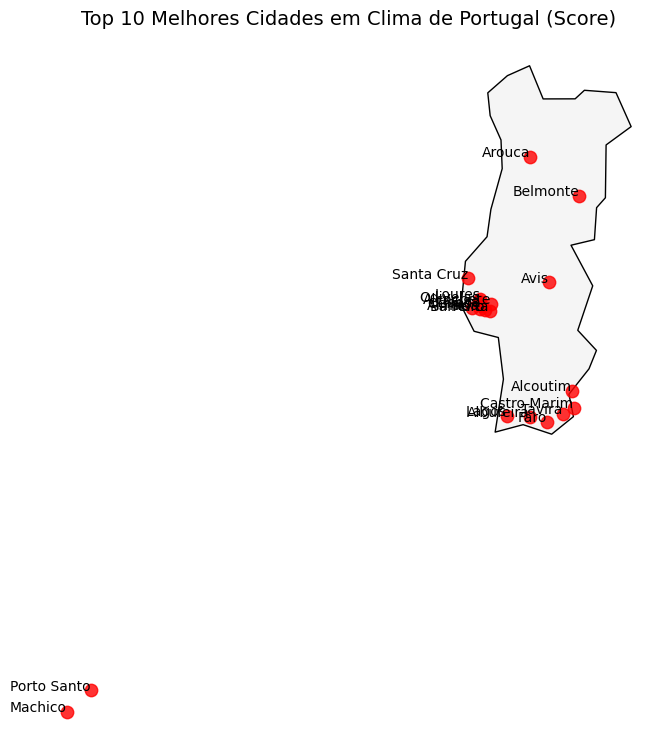

In [146]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Caminho para o arquivo shapefile (.shp)
shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Admin 0 – Countries\\ne_110m_admin_0_countries.shp'

# Carrega o shapefile
portugal = gpd.read_file(shapefile_path)
portugal = portugal[portugal['NAME'] == 'Portugal']  # Coluna pode ser 'NAME' ou 'name' dependendo do shape

# Cria GeoDataFrame das cidades
gdf = gpd.GeoDataFrame(
    top10,
    geometry=gpd.points_from_xy(top10['longitude'], top10['latitude']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(8,10))
portugal.plot(ax=ax, color='whitesmoke', edgecolor='black')
gdf.plot(ax=ax, color='red', markersize=80, alpha=0.8)

# Adiciona o nome das cidades
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['location']):
    ax.text(x, y, label, fontsize=10, ha='right')

plt.title('Top 10 Melhores Cidades em Clima de Portugal (Score)', fontsize=14)
plt.axis('off')
plt.show()


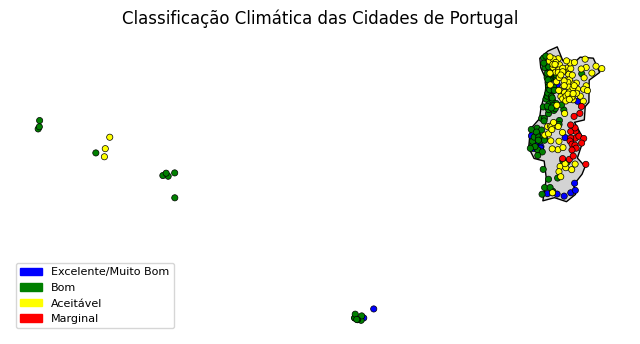

In [147]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Dicionário de cores
cores = {
    'Excelente': 'blue',
    'Muito Bom': 'blue',
    'Bom': 'green',
    'Aceitável': 'yellow',
    'Marginal': 'red'
}
ranking_geo['cor'] = ranking_geo['classificacao'].map(cores)

# Converte para GeoDataFrame
gdf = gpd.GeoDataFrame(
    ranking_geo, geometry=gpd.points_from_xy(ranking_geo.longitude, ranking_geo.latitude), crs="EPSG:4326"
)

# Carrega o shapefile de Portugal (pode ajustar o caminho e a coluna se necessário)
shapefile_path = '..\\..\\Bases\\Geocoding\\files\\Admin 0 – Countries\\ne_110m_admin_0_countries.shp'
portugal = gpd.read_file(shapefile_path)
portugal = portugal[portugal['NAME'] == 'Portugal']

# Plota o mapa
fig, ax = plt.subplots(figsize=(8, 10))
portugal.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color=gdf['cor'], markersize=20, marker='o', edgecolor='black', linewidth=0.5)

# Adiciona legenda
import matplotlib.patches as mpatches
patches = [
    mpatches.Patch(color='blue', label='Excelente/Muito Bom'),
    mpatches.Patch(color='green', label='Bom'),
    mpatches.Patch(color='yellow', label='Aceitável'),
    mpatches.Patch(color='red', label='Marginal')
]
plt.legend(handles=patches, loc='lower left', fontsize=8)

plt.title('Classificação Climática das Cidades de Portugal')
plt.axis('off')
plt.show()

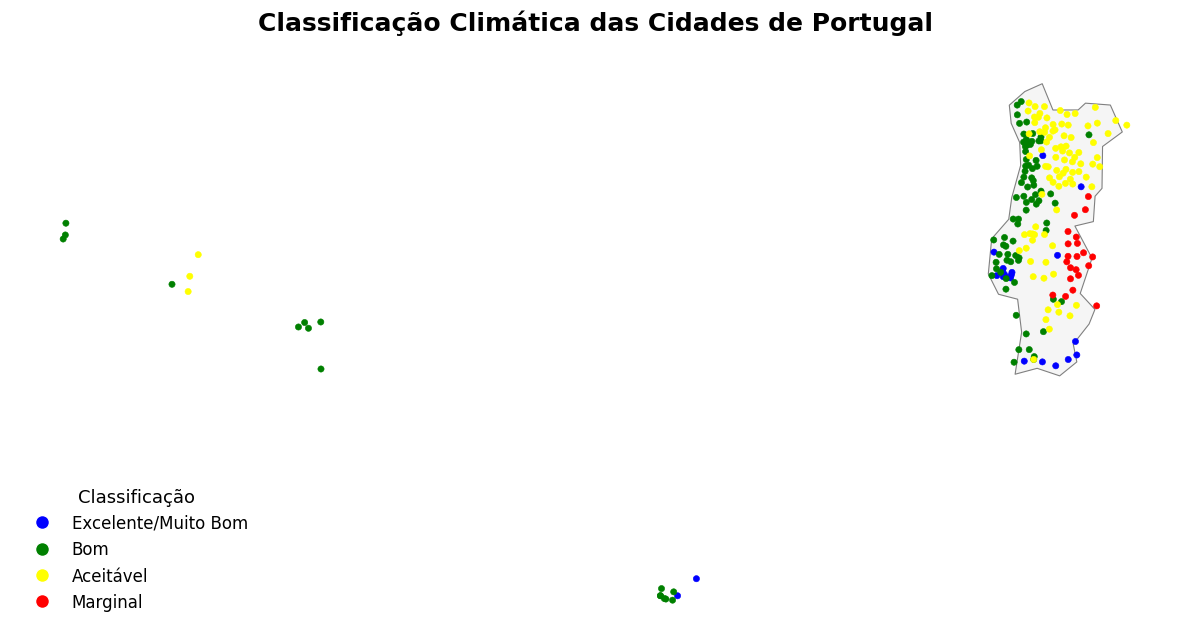

In [148]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 16))

portugal.plot(ax=ax, color='whitesmoke', edgecolor='gray', linewidth=0.8)
gdf.plot(ax=ax, color=gdf['cor'], markersize=20, marker='o', linewidth=0.4)

plt.axis('off')
plt.title('Classificação Climática das Cidades de Portugal', fontsize=18, weight='bold', pad=20)

# Legenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Excelente/Muito Bom', markerfacecolor=cores['Excelente'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Bom', markerfacecolor=cores['Bom'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Aceitável', markerfacecolor=cores['Aceitável'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Marginal', markerfacecolor=cores['Marginal'], markersize=10),
]
ax.legend(handles=legend_elements, title="Classificação", loc='lower left', frameon=False, fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()

In [132]:
!pip install dataframe_image

     ---------------------------------------- 6.7/6.7 MB 6.1 MB/s eta 0:00:00
     -------------------------------------- 258.5/258.5 kB 8.0 MB/s eta 0:00:00
     -------------------------------------- 452.3/452.3 kB 5.6 MB/s eta 0:00:00
     -------------------------------------- 53.4/53.4 kB 918.5 kB/s eta 0:00:00
     --------------------------------------- 35.4/35.4 MB 16.4 MB/s eta 0:00:00
     ---------------------------------------- 44.0/44.0 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 45.9/45.9 kB 151.9 kB/s eta 0:00:00
     ---------------------------------------- 41.5/41.5 kB 1.0 MB/s eta 0:00:00
     -------------------------------------- 86.7/86.7 kB 181.2 kB/s eta 0:00:00
     ------------------------------------- 163.4/163.4 kB 10.2 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 2.2 MB/s eta 0:00:00
     -------------------------------------- 297.0/297.0 kB 9.3 MB/s eta 0:00:00


In [138]:
ranking_geo['score']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
222   NaN
223   NaN
224   NaN
225   NaN
226   NaN
Name: score, Length: 227, dtype: float64

In [153]:
# Define a ordem desejada dos grupos
ordem_grupos = ['Muito Bom', 'Bom', 'Aceitável', 'Marginal']

# Corrige as colunas numéricas caso estejam com vírgula
for col in ['score', 'maxtempC', 'mintempC']:
    ranking_geo[col] = (
        ranking_geo[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )

for col in ['calor_extremo', 'frio_extremo', 'chuva_extrema', 'neve', 'uv_extremo']:
    ranking_geo[col] = (
        ranking_geo[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .astype(float)
        .astype(int)
    )

# Cria coluna de total de eventos extremos
ranking_geo['eventos_extremos'] = (
    ranking_geo['calor_extremo'] +
    ranking_geo['frio_extremo'] +
    ranking_geo['chuva_extrema'] +
    ranking_geo['neve'] +
    ranking_geo['uv_extremo']
)

# Cria a lista ordenada
texto = '🏆 Ranking de Cidades por Categoria Climática 🏆\n'
for cat in ordem_grupos:
    grupo = ranking_geo[ranking_geo['classificacao'] == cat].sort_values('score', ascending=False)
    if not grupo.empty:
        texto += f'\n🔵 {cat}:\n'
        for _, row in grupo.iterrows():
            texto += (
                f"   - {row['location']}: {row['score']:.1f} pontos | "
                f"Extremos: {row['eventos_extremos']} | "
                f"Máx: {row['maxtempC']:.1f}°C | "
                f"Mín: {row['mintempC']:.1f}°C\n"
            )

print(texto)


🏆 Ranking de Cidades por Categoria Climática 🏆

🔵 Muito Bom:
   - Santa Cruz: 76.8 pontos | Extremos: 10 | Máx: 21.0°C | Mín: 16.9°C
   - Machico: 76.8 pontos | Extremos: 10 | Máx: 21.0°C | Mín: 16.9°C
   - Porto Santo: 75.6 pontos | Extremos: 2 | Máx: 20.1°C | Mín: 19.2°C
   - Avis: 74.8 pontos | Extremos: 3 | Máx: 26.6°C | Mín: 13.4°C
   - Belmonte: 73.5 pontos | Extremos: 11 | Máx: 21.3°C | Mín: 15.6°C
   - Faro: 73.5 pontos | Extremos: 14 | Máx: 21.2°C | Mín: 15.7°C
   - Lagos: 73.1 pontos | Extremos: 8 | Máx: 20.8°C | Mín: 14.8°C
   - Almada: 71.8 pontos | Extremos: 8 | Máx: 21.6°C | Mín: 13.9°C
   - Barreiro: 71.8 pontos | Extremos: 8 | Máx: 21.6°C | Mín: 13.9°C
   - Castro Marim: 71.6 pontos | Extremos: 13 | Máx: 22.2°C | Mín: 14.8°C
   - Tavira: 71.6 pontos | Extremos: 13 | Máx: 22.2°C | Mín: 14.8°C
   - Arouca: 71.6 pontos | Extremos: 15 | Máx: 21.8°C | Mín: 14.9°C
   - Alcoutim: 71.5 pontos | Extremos: 13 | Máx: 22.2°C | Mín: 14.8°C
   - Odivelas: 71.4 pontos | Extremos: 13 |